In [1]:
import pandas as pd
import random
from datasets import load_dataset
from transformers import (
    DataCollatorForLanguageModeling,
    TrainingArguments,
    Trainer,
)
import math
import matplotlib.pyplot as plt
import numpy as np
import os

/home/liorkob/.conda/envs/judgeEnv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


###  Data

📊 Dataset Statistics
Total facts: 2987
Train set size: 2389
Eval set size:  299
Test set size:  299

📎 Word Counts
Min: 7
Max: 1910
Mean: 224.50
Median: 170


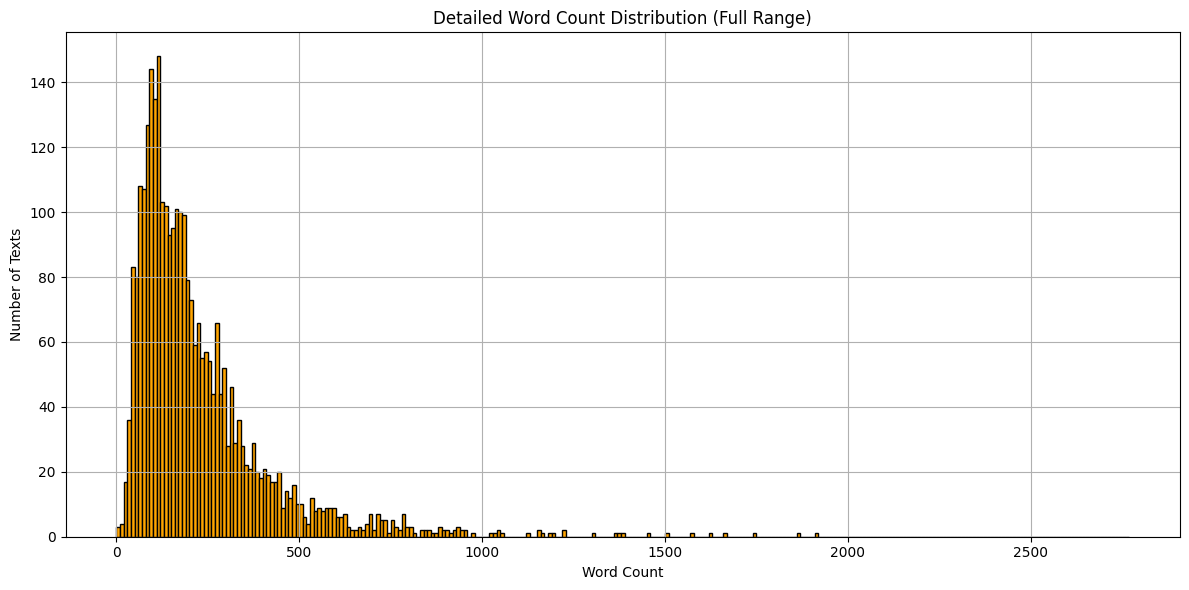

In [ ]:
# ======== Load and Combine Data ========
df1 = pd.read_csv("/home/liorkob/M.Sc/thesis/data/drugs_3k/gpt/processed_verdicts_with_gpt.csv")
texts =df1["extracted_gpt_facts"].dropna().tolist()

# ======== Shuffle and Split (80/10/10) ========
random.seed(42)
random.shuffle(texts)
n = len(texts)

train_texts = texts[:int(n*0.8)]
eval_texts = texts[int(n*0.8):int(n*0.9)]
test_texts = texts[int(n*0.9):]

# ======== Save Files ========
with open("/home/liorkob/M.Sc/thesis/pre-train/data_splits/gpt_facts.txt", "w", encoding="utf-8") as f:
    for line in train_texts:
        f.write(line.strip() + "\n")

with open("/home/liorkob/M.Sc/thesis/pre-train/data_splits/eval.txt", "w", encoding="utf-8") as f:
    for line in eval_texts:
        f.write(line.strip() + "\n")

with open("/home/liorkob/M.Sc/thesis/pre-train/data_splits/est.txt", "w", encoding="utf-8") as f:
    for line in test_texts:
        f.write(line.strip() + "\n")

# =======================
# Print Statistics
# =======================
print("📊 Dataset Statistics")
print(f"Total facts: {len(texts)}")
print(f"Train set size: {len(train_texts)}")
print(f"Eval set size:  {len(eval_texts)}")
print(f"Test set size:  {len(test_texts)}")


# Word count per fact
word_counts = [len(t.split()) for t in texts]
print("\n📎 Word Counts")
print(f"Min: {min(word_counts)}")
print(f"Max: {max(word_counts)}")
print(f"Mean: {sum(word_counts)/len(word_counts):.2f}")
print(f"Median: {sorted(word_counts)[len(word_counts)//2]}")
# Plot detailed histogram
plt.figure(figsize=(12, 6))
plt.hist(word_counts, bins=np.arange(0, 2762 + 10, 10), edgecolor='black', color='orange')
plt.title("Detailed Word Count Distribution (Full Range)")
plt.xlabel("Word Count")
plt.ylabel("Number of Texts")
plt.grid(True)
plt.tight_layout()
plt.show()



### tokenizer

In [2]:
from transformers import AutoTokenizer
from collections import Counter
import re

# טעני את הטוקנייזר המקורי
tokenizer = AutoTokenizer.from_pretrained("avichr/Legal-heBERT")

# טעני את הטקסטים
with open("/home/liorkob/M.Sc/thesis/pre-train/data_splits/gpt_facts.txt", "r", encoding="utf-8") as f:
    texts = [line.strip() for line in f if line.strip()]

# הגדרת ניקוי טקסט בסיסי 
def clean(text):
    return re.sub(r"[^\w\s]", "", text)

# סופרת ביטויים שמחולקים ליותר מטוקן אחד
split_phrases = Counter()

for text in texts:
    words = clean(text).split()
    for word in words:
        tokens = tokenizer.tokenize(word)
        if len(tokens) > 1:  # מילה שנחתכת
            split_phrases[word] += 1

# בוחרת טוקנים נפוצים שנחתכים הרבה
top_new_tokens = [w for w, c in split_phrases.most_common(100) if w not in tokenizer.vocab]
# ======== Load Tokenizer and Model ========
from transformers import AutoTokenizer, AutoModelForMaskedLM

# טען את הטוקנייזר והמודל המקוריים
model_name = "google-bert/bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForMaskedLM.from_pretrained(model_name)

# הוספת טוקנים חדשים
new_tokens = top_new_tokens[:100]  # מתוך הקוד שלך למעלה
num_added_tokens = tokenizer.add_tokens(new_tokens)
print(f"🧩 Added {num_added_tokens} new tokens")

# עדכון המודל לגודל החדש של הווקאב
model.resize_token_embeddings(len(tokenizer))


BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of the model checkpoint at google-bert/bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.p

🧩 Added 100 new tokens


The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Embedding(119646, 768, padding_idx=0)

### ft mlm

Map: 100%|██████████| 1603/1603 [00:00<00:00, 3788.12 examples/s]
/home/liorkob/.conda/envs/judgeEnv/lib/python3.8/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,1.193900,1.031499
2,0.972800,0.967504
3,0.958500,0.906931
4,0.840700,0.827959
5,0.781200,0.808048
6,0.755500,0.777053
7,0.774600,0.784302
8,0.740100,0.733033
9,0.674200,0.730785
10,0.644400,0.723072


There were missing keys in the checkpoint model loaded: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias'].


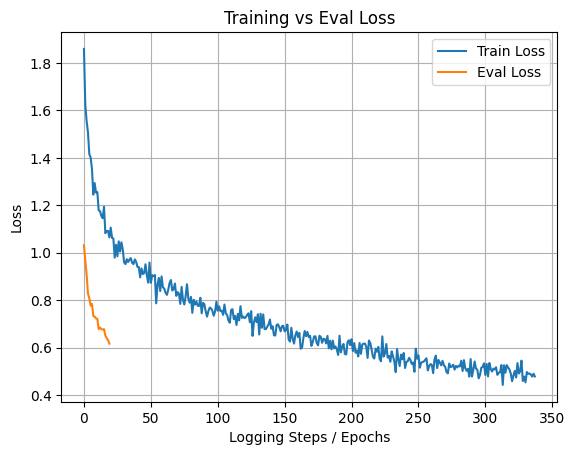

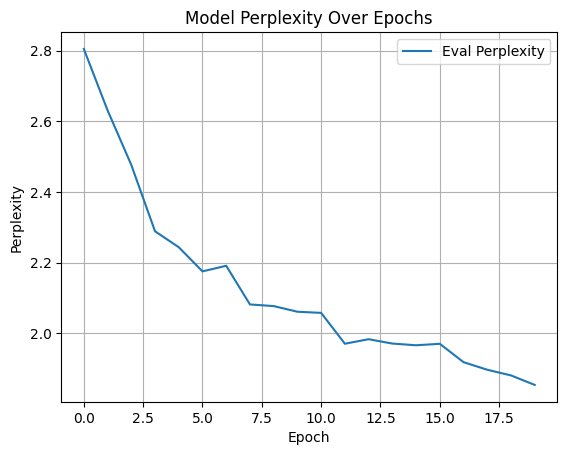

🔍 Final Test Perplexity: 1.9169175448608011


In [3]:

os.environ["TOKENIZERS_PARALLELISM"] = "false"

# ======== Load Datasets ========
dataset = load_dataset("text", data_files={"train": "/home/liorkob/M.Sc/thesis/pre-train/data_splits/gpt_facts.txt"})
eval_dataset = load_dataset("text", data_files={"eval": "/home/liorkob/M.Sc/thesis/pre-train/data_splits/eval.txt"})
test_dataset = load_dataset("text", data_files={"test": "/home/liorkob/M.Sc/thesis/pre-train/data_splits/test.txt"})

# ======== Tokenization ========
def sliding_tokenize_function(examples):
    return tokenizer(
        examples["text"],
        max_length=512,
        stride=256,
        truncation=True,
        padding="max_length",
        return_overflowing_tokens=True
    )

tokenized_train = dataset.map(sliding_tokenize_function, batched=True, remove_columns=["text"])
tokenized_eval = eval_dataset.map(sliding_tokenize_function, batched=True, remove_columns=["text"])
tokenized_test = test_dataset.map(sliding_tokenize_function, batched=True, remove_columns=["text"])

# ======== Training Arguments ========
training_args = TrainingArguments(
    output_dir="./mBERT-mlm-3k-drugs",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=20,
    evaluation_strategy="epoch",
    save_strategy="epoch", 
    save_total_limit=2,
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss"
)

# ======== Data Collator for MLM ========
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=0.15
)

# ======== Trainer ========
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train["train"],
    eval_dataset=tokenized_eval["eval"],
    data_collator=data_collator
)

# ======== Training ========
trainer.train()
trainer.save_model("./mBERT-mlm-3k-drugs/final")
tokenizer.save_pretrained("./mBERT-mlm-3k-drugs/final")

# ======== Plots ========
log_history = trainer.state.log_history
train_loss = [x["loss"] for x in log_history if "loss" in x]
eval_loss = [x["eval_loss"] for x in log_history if "eval_loss" in x]

plt.plot(train_loss, label="Train Loss")
plt.plot(eval_loss, label="Eval Loss")
plt.xlabel("Logging Steps / Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Eval Loss")
plt.grid(True)
plt.show()

perplexities = [math.exp(loss) for loss in eval_loss]
plt.plot(perplexities, label="Eval Perplexity")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.title("Model Perplexity Over Epochs")
plt.grid(True)
plt.legend()
plt.show()

# ======== Final Test Evaluation ========
test_results = trainer.evaluate(eval_dataset=tokenized_test["test"])
print("🔍 Final Test Perplexity:", math.exp(test_results["eval_loss"]))


In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")  

def get_token_count(example):
    return {"token_count": len(tokenizer(example["text"], add_special_tokens=True)["input_ids"])}

total_tokens = 0
total_texts = 0

for split_name, split_dataset in dataset.items():
    tokenized_dataset = split_dataset.map(get_token_count)
    split_total = sum(tokenized_dataset["token_count"])
    split_count = len(tokenized_dataset)

    avg = split_total / split_count
    print(f"{split_name} - ממוצע טוקנים: {avg:.2f}")

    total_tokens += split_total
    total_texts += split_count

print(f"\nסה\"כ ממוצע טוקנים בכל הדאטה: {total_tokens / total_texts:.2f}")


Map:   0%|          | 0/13892 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1123 > 512). Running this sequence through the model will result in indexing errors


train - ממוצע טוקנים: 178.19

סה"כ ממוצע טוקנים בכל הדאטה: 178.19


In [ ]:
# הערכה וחישוב Perplexity
eval_results = trainer.evaluate(eval_dataset=tokenized_eval["eval"])
perplexity = math.exp(eval_results["eval_loss"])
print("Perplexity:", perplexity)


Perplexity: 3.901851828246573


In [ ]:
# from transformers import AutoTokenizer
# from collections import Counter
# import re

# # טעני את הטוקנייזר המקורי
# tokenizer = AutoTokenizer.from_pretrained("avichr/heBERT")

# # טעני את הטקסטים
# with open("gpt_facts.txt", "r", encoding="utf-8") as f:
#     texts = [line.strip() for line in f if line.strip()]

# # הגדרת ניקוי טקסט בסיסי 
# def clean(text):
#     return re.sub(r"[^\w\s]", "", text)

# # סופרת ביטויים שמחולקים ליותר מטוקן אחד
# split_phrases = Counter()

# for text in texts:
#     words = clean(text).split()
#     for word in words:
#         tokens = tokenizer.tokenize(word)
#         if len(tokens) > 1:  # מילה שנחתכת
#             split_phrases[word] += 1

# # בוחרת טוקנים נפוצים שנחתכים הרבה
# top_new_tokens = [w for w, c in split_phrases.most_common(100) if w not in tokenizer.vocab]
# # ======== Load Tokenizer and Model ========
# from transformers import AutoTokenizer, AutoModelForMaskedLM

# # טען את הטוקנייזר והמודל המקוריים
# model_name = "avichr/heBERT"
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModelForMaskedLM.from_pretrained(model_name)

# # הוספת טוקנים חדשים
# new_tokens = top_new_tokens[:100]  # מתוך הקוד שלך למעלה
# num_added_tokens = tokenizer.add_tokens(new_tokens)
# print(f"🧩 Added {num_added_tokens} new tokens")

# # עדכון המודל לגודל החדש של הווקאב
# model.resize_token_embeddings(len(tokenizer))


BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


🧩 Added 100 new tokens


Embedding(30100, 768, padding_idx=0)

### ft mlm

Map:   0%|          | 0/13174 [00:00<?, ? examples/s]

Map:   0%|          | 0/1748 [00:00<?, ? examples/s]

Map:   0%|          | 0/1603 [00:00<?, ? examples/s]

/home/liorkob/.conda/envs/new_env/lib/python3.9/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,2.289000,2.088770
2,2.055400,1.902692
3,1.947000,1.773776
4,1.853700,1.683798
5,1.714800,1.598312
6,1.630500,1.503084
7,1.334900,1.474212
8,1.326700,1.418795
9,1.287900,1.440794
10,1.247200,1.414144


There were missing keys in the checkpoint model loaded: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias'].


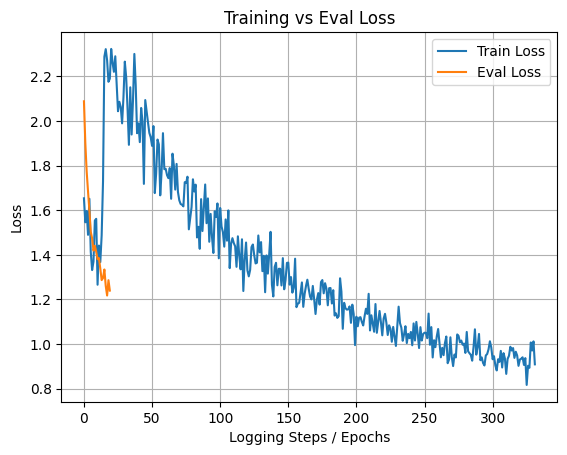

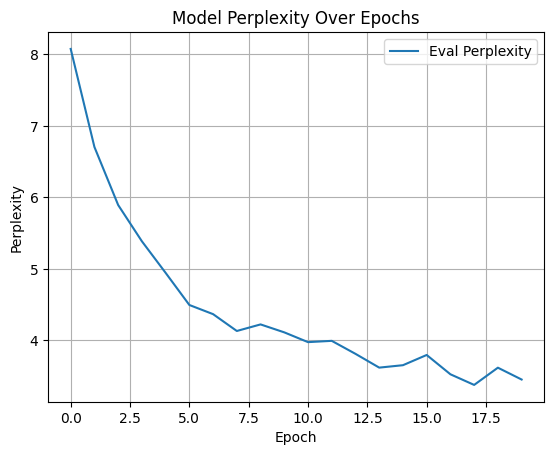

🔍 Final Test Perplexity: 3.7342975144415713


In [ ]:

# os.environ["TOKENIZERS_PARALLELISM"] = "false"

# # ======== Load Datasets ========
# dataset = load_dataset("text", data_files={"train": "gpt_facts.txt"})
# eval_dataset = load_dataset("text", data_files={"eval": "eval.txt"})
# test_dataset = load_dataset("text", data_files={"test": "test.txt"})

# # ======== Tokenization ========
# def sliding_tokenize_function(examples):
#     return tokenizer(
#         examples["text"],
#         max_length=512,
#         stride=256,
#         truncation=True,
#         padding="max_length",
#         return_overflowing_tokens=True
#     )

# tokenized_train = dataset.map(sliding_tokenize_function, batched=True, remove_columns=["text"])
# tokenized_eval = eval_dataset.map(sliding_tokenize_function, batched=True, remove_columns=["text"])
# tokenized_test = test_dataset.map(sliding_tokenize_function, batched=True, remove_columns=["text"])

# # ======== Training Arguments ========
# training_args = TrainingArguments(
#     output_dir="./hebert-mlm-3k-drugs",
#     logging_dir="./mlm-3k-drugs/logs",
#     per_device_train_batch_size=8,
#     per_device_eval_batch_size=8,
#     num_train_epochs=20,
#     evaluation_strategy="epoch",
#     save_strategy="epoch", 
#     save_total_limit=2,
#     logging_steps=100,
#     load_best_model_at_end=True,
#     metric_for_best_model="eval_loss"
# )

# # ======== Data Collator for MLM ========
# data_collator = DataCollatorForLanguageModeling(
#     tokenizer=tokenizer, mlm=True, mlm_probability=0.15
# )

# # ======== Trainer ========
# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=tokenized_train["train"],
#     eval_dataset=tokenized_eval["eval"],
#     data_collator=data_collator
# )

# # ======== Training ========
# trainer.train()
# trainer.save_model("./hebert-mlm-3k-drugs/final")
# tokenizer.save_pretrained("./hebert-mlm-3k-drugs/final")

# # ======== Plots ========
# log_history = trainer.state.log_history
# train_loss = [x["loss"] for x in log_history if "loss" in x]
# eval_loss = [x["eval_loss"] for x in log_history if "eval_loss" in x]

# plt.plot(train_loss, label="Train Loss")
# plt.plot(eval_loss, label="Eval Loss")
# plt.xlabel("Logging Steps / Epochs")
# plt.ylabel("Loss")
# plt.legend()
# plt.title("Training vs Eval Loss")
# plt.grid(True)
# plt.show()

# perplexities = [math.exp(loss) for loss in eval_loss]
# plt.plot(perplexities, label="Eval Perplexity")
# plt.xlabel("Epoch")
# plt.ylabel("Perplexity")
# plt.title("Model Perplexity Over Epochs")
# plt.grid(True)
# plt.legend()
# plt.show()

# # ======== Final Test Evaluation ========
# test_results = trainer.evaluate(eval_dataset=tokenized_test["test"])
# print("🔍 Final Test Perplexity:", math.exp(test_results["eval_loss"]))


In [ ]:
# from transformers import AutoTokenizer

# tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")  

# def get_token_count(example):
#     return {"token_count": len(tokenizer(example["text"], add_special_tokens=True)["input_ids"])}

# total_tokens = 0
# total_texts = 0

# for split_name, split_dataset in dataset.items():
#     tokenized_dataset = split_dataset.map(get_token_count)
#     split_total = sum(tokenized_dataset["token_count"])
#     split_count = len(tokenized_dataset)

#     avg = split_total / split_count
#     print(f"{split_name} - ממוצע טוקנים: {avg:.2f}")

#     total_tokens += split_total
#     total_texts += split_count

# print(f"\nסה\"כ ממוצע טוקנים בכל הדאטה: {total_tokens / total_texts:.2f}")


Map:   0%|          | 0/13892 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1123 > 512). Running this sequence through the model will result in indexing errors


train - ממוצע טוקנים: 178.19

סה"כ ממוצע טוקנים בכל הדאטה: 178.19


In [ ]:
# # הערכה וחישוב Perplexity
# eval_results = trainer.evaluate(eval_dataset=tokenized_eval["eval"])
# perplexity = math.exp(eval_results["eval_loss"])
# print("Perplexity:", perplexity)


Perplexity: 3.901851828246573


## baseline 

In [1]:
from transformers import AutoTokenizer, AutoModelForMaskedLM
baseline_model = AutoModelForMaskedLM.from_pretrained("avichr/heBERT")
# baseline_tokenizer = AutoTokenizer.from_pretrained("avichr/heBERT")
baseline_tokenizer = AutoTokenizer.from_pretrained("/home/liorkob/M.Sc/thesis/pre-train/models/hebert-mlm-3k-drugs/final")

from datasets import load_dataset

test_dataset = load_dataset("text", data_files={"test": "/home/liorkob/M.Sc/thesis/pre-train/data_splits/test.txt"})
def sliding_tokenize_function(examples):
    return baseline_tokenizer(
        examples["text"],
        max_length=512,
        stride=256,
        truncation=True,
        padding="max_length",
        return_overflowing_tokens=True
    )

tokenized_test = test_dataset.map(sliding_tokenize_function, batched=True, remove_columns=["text"])
from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling
import math

data_collator = DataCollatorForLanguageModeling(
    tokenizer=baseline_tokenizer, mlm=True, mlm_probability=0.15
)

baseline_trainer = Trainer(
    model=baseline_model,
    args=TrainingArguments(output_dir="./baseline", per_device_eval_batch_size=8),
    eval_dataset=tokenized_test["test"],
    data_collator=data_collator
)

baseline_results = baseline_trainer.evaluate()
print("📉 Baseline Perplexity:", math.exp(baseline_results["eval_loss"]))


/home/liorkob/.conda/envs/judgeEnv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If y

📉 Baseline Perplexity: 42.23018348578223


### tokenizer check

In [ ]:
from transformers import AutoTokenizer
from collections import Counter
import re

# טעני את הטוקנייזר המקורי
tokenizer = AutoTokenizer.from_pretrained("avichr/heBERT")

# טעני את הטקסטים
with open("gpt_facts.txt", "r", encoding="utf-8") as f:
    texts = [line.strip() for line in f if line.strip()]

# הגדרת ניקוי טקסט בסיסי (רשותי)
def clean(text):
    return re.sub(r"[^\w\s]", "", text)

# סופרת ביטויים שמחולקים ליותר מטוקן אחד
split_phrases = Counter()

for text in texts:
    words = clean(text).split()
    for word in words:
        tokens = tokenizer.tokenize(word)
        if len(tokens) > 1:  # מילה שנחתכת
            split_phrases[word] += 1

# בוחרת טוקנים נפוצים שנחתכים הרבה
top_new_tokens = [w for w, c in split_phrases.most_common(100) if w not in tokenizer.vocab]

# מדפיסה הצעות להוספה
print("📌 מומלץ להוסיף טוקנים:")
print(top_new_tokens[:100])



📌 מומלץ להוסיף טוקנים:
['המסוכנים', 'לצריכה', 'קנבוס', 'המתוקן', 'הודאתו', 'הסם', 'בסם', 'קוקאין', 'רישא', 'חשיש', 'בעובדות', '7א', 'לסוכן', 'מתוקן', 'באישום', 'קנביס', 'תשלג', 'למאשימה', '19א', 'והנאשם', 'והורשע', 'תשלג1973', 'סיפא', 'לצריכתו', '7ג', 'קג', 'לעונש', 'תסקיר', 'MDMA', 'לשוטר', 'התשלג1973', 'גידל', 'בצוותא', 'המתואר', 'עלפי', 'ברכבו', 'שתילים', 'ומסר', 'התשלג', 'התשלז1977', 'והחזקת', 'שהנאשם', 'דיוני', 'אישומים', '7אג', 'מעובדות', 'לעובדות', '7א7ג', 'ובעבירה', 'הרואין', 'והסוכן', 'תשלז', 'שתילי', 'להודאתו', 'התשלז', 'במועדים', 'משטרתי', 'מהנאשם', 'תשלז1977', 'שזהותו', 'תחמושת', 'בעבירת', 'בפקודת', 'תוקן', 'והשניים', 'עונשית', 'ו19א', 'טבליות', 'ומכר', 'בנאשם', 'המייחס', 'המסוכן', 'לסך', 'סיכמו', 'במעשיו', 'סמוי', 'מאווררים', 'חדא', 'ובתמורה', 'המצורף', 'למתואר', 'דישון', 'קשירת', 'לסחר', '275', 'וסעיף', 'ו7ג', 'אדניות', 'מהרכב', 'שנאים', 'במיוחס', 'פסילה', 'בהחזקת', 'מהאישום', 'הורשעו', 'לגרם', 'שהכילו', 'צירף', 'בדירתו', 'יישומון']


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("avichr/heBERT")

words = top_new_tokens[:100]
for word in words:
    tokens = tokenizer.tokenize(word)
    print(f"{word}  ➜  {tokens}")


המסוכנים  ➜  ['המס', '##וכנים']
לצריכה  ➜  ['לצ', '##ריכה']
קנבוס  ➜  ['קנ', '##בוס']
המתוקן  ➜  ['המתוק', '##ן']
הודאתו  ➜  ['הוד', '##אתו']
הסם  ➜  ['הס', '##ם']
בסם  ➜  ['בס', '##ם']
קוקאין  ➜  ['קוק', '##אין']
רישא  ➜  ['ריש', '##א']
חשיש  ➜  ['חש', '##יש']
בעובדות  ➜  ['בע', '##ובדות']
7א  ➜  ['7', '##א']
לסוכן  ➜  ['לס', '##וכן']
מתוקן  ➜  ['מתוק', '##ן']
באישום  ➜  ['באיש', '##ום']
קנביס  ➜  ['קנ', '##ביס']
תשלג  ➜  ['תשל', '##ג']
למאשימה  ➜  ['למא', '##שימה']
19א  ➜  ['19', '##א']
והנאשם  ➜  ['והנ', '##אש', '##ם']
והורשע  ➜  ['והור', '##שע']
תשלג1973  ➜  ['תשל', '##ג', '##19', '##73']
סיפא  ➜  ['סיפ', '##א']
לצריכתו  ➜  ['לצ', '##ריכת', '##ו']
7ג  ➜  ['7', '##ג']
קג  ➜  ['ק', '##ג']
לעונש  ➜  ['לעו', '##נש']
תסקיר  ➜  ['תס', '##קי', '##ר']
MDMA  ➜  ['m', '##d', '##ma']
לשוטר  ➜  ['לשו', '##טר']
התשלג1973  ➜  ['התשל', '##ג', '##19', '##73']
גידל  ➜  ['גיד', '##ל']
בצוותא  ➜  ['בצוות', '##א']
המתואר  ➜  ['המת', '##ואר']
עלפי  ➜  ['על', '##פי']
ברכבו  ➜  ['ברכב', '##ו']
שתילים  ➜ 

### Perplexity compere

In [ ]:
# Use your own dataset or a public one
texts = pd.read_csv("/home/liorkob/M.Sc/thesis/data/drugs_3k/gpt/processed_verdicts_with_gpt.csv")["extracted_gpt_facts"].dropna().tolist()
texts = texts[:1000]  # Shorten for speed
from datasets import Dataset

# Create a Dataset object
dataset = Dataset.from_dict({"text": texts})
from transformers import AutoModelForMaskedLM, AutoTokenizer, DataCollatorForLanguageModeling
from datasets import Dataset
from torch.utils.data import DataLoader
import torch
import math
from tqdm import tqdm
import pandas as pd

def evaluate_mlm_perplexity(model_path, text_list, device):
    model = AutoModelForMaskedLM.from_pretrained(model_path).to(device)
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model.eval()

    dataset = Dataset.from_dict({"text": text_list})
    def tokenize_function(examples):
        return tokenizer(examples["text"], truncation=True, max_length=512)
    tokenized_dataset = dataset.map(tokenize_function, batched=True, remove_columns=["text"])

    collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=True, mlm_probability=0.15)
    dataloader = DataLoader(tokenized_dataset, batch_size=8, shuffle=False, collate_fn=collator)

    total_loss = 0
    num_batches = 0
    with torch.no_grad():
        for batch in tqdm(dataloader, desc=f"Evaluating {model_path}"):
            batch = {k: v.to(device) for k, v in batch.items()}
            loss = model(**batch).loss
            total_loss += loss.item()
            num_batches += 1

    avg_loss = total_loss / num_batches
    perplexity = math.exp(avg_loss)
    return avg_loss, perplexity
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mlm_model_path = "/home/liorkob/M.Sc/thesis/pre-train/hebert-mlm-3k-drugs/final"
base_model_path = "avichr/heBERT"

loss_base, ppl_base = evaluate_mlm_perplexity(base_model_path, texts, device)
loss_mlm, ppl_mlm = evaluate_mlm_perplexity(mlm_model_path, texts, device)

print(f"\n🔹 Base HeBERT — Loss: {loss_base:.4f}, Perplexity: {ppl_base:.2f}")
print(f"🔸 Fine-tuned MLM — Loss: {loss_mlm:.4f}, Perplexity: {ppl_mlm:.2f}")


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Evaluating avichr/heBERT: 100%|██████████| 125/125 [00:04<00:00, 27.10it/s]


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Evaluating /home/liorkob/M.Sc/thesis/pre-train/hebert-mlm-3k-drugs/final: 100%|██████████| 125/125 [00:04<00:00, 26.94it/s]


🔹 Base HeBERT — Loss: 5.0476, Perplexity: 155.65
🔸 Fine-tuned MLM — Loss: 1.8170, Perplexity: 6.15


### quality check

In [7]:
from transformers import pipeline, AutoTokenizer, AutoModelForMaskedLM
from datasets import load_dataset
import random
import re
import os

# ======== 2. Load fine-tuned tokenizer and model ========
model_path = "./hebert-mlm-3k-drugs/final"  # הנתיב למודל שלך

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForMaskedLM.from_pretrained(model_path)

# ======== 3. Load and clean texts ========
with open("gpt_facts.txt", "r", encoding="utf-8") as f:
    texts = [line.strip() for line in f if line.strip()]

def clean(text):
    return re.sub(r"[^\w\s]", "", text)

texts = [clean(t) for t in texts if len(t.split()) > 5]

# ======== 4. Masking function ========
def mask_random_word(text):
    words = text.split()
    idx = random.randint(0, len(words) - 1)
    original_word = words[idx]
    words[idx] = tokenizer.mask_token
    return " ".join(words), original_word

# ======== 5. Load pipeline ========
os.environ["TOKENIZERS_PARALLELISM"] = "false"
fill_mask = pipeline("fill-mask", model=model, tokenizer=tokenizer, top_k=5)

# ======== 6. Show predictions ========
for i in range(5):  # 5 דוגמאות לבדיקה
    text = random.choice(texts)
    masked_text, true_word = mask_random_word(text)
    print(f"\n🟦 Original: {text}")
    print(f"🟨 Masked : {masked_text}")
    print(f"🟩 True word: {true_word}")
    predictions = fill_mask(masked_text)
    for pred in predictions:
        print(f"🔹 {pred['token_str']} (score: {pred['score']:.4f})")


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.



🟦 Original: על יסוד הודאת הנאשם הנני מרשיע אותו בעבירה של סיוע לסחר בסם מסוכן עבירה לפי סעיף 13  19א לפקודת הסמים המסוכנים יחד עם סעיף 31 לחוק העונשין הנאשם הורשע עלפי הודאתו בעבירה של סיוע לסחר בסם מסוכן
🟨 Masked : על יסוד הודאת הנאשם הנני מרשיע אותו בעבירה של סיוע לסחר בסם מסוכן עבירה לפי סעיף 13 19א לפקודת הסמים המסוכנים יחד עם סעיף 31 לחוק העונשין הנאשם הורשע עלפי הודאתו בעבירה של [MASK] לסחר בסם מסוכן
🟩 True word: סיוע
🔹 סיוע (score: 0.9575)
🔹 תיווך (score: 0.0311)
🔹 ניסיון (score: 0.0106)
🔹 בסיוע (score: 0.0002)
🔹 סייע (score: 0.0001)

🟦 Original: הנאשם הורשע לפי הודאתו במסגרת הסדר טיעון בכך שביום 26112015 החזיק בתוך שקית שבתוך ארגז קרטון בקיוסק שבו עבד 30 שקיות של סם מסוכן מסוג ABCHMINACA לצריכתו העצמית במעשהו הפר הנאשם את האיסור שקבעה המדינה על החזקת שורת חומרים מסוימים משני תודעה ללא היתר מטעם המדינה
🟨 Masked : הנאשם הורשע לפי הודאתו במסגרת הסדר טיעון בכך שביום 26112015 החזיק בתוך שקית שבתוך ארגז קרטון בקיוסק שבו עבד 30 שקיות של סם מסוכן מסוג ABCHMINACA לצריכתו העצמית במעשהו 

In [8]:
# תוצאה אוטומטית של הצלחה:
# האם המילה האמיתית בתוך top-1? top-5?
# אחוז ההצלחה
correct_top1 = 0
correct_top5 = 0
total = 100  

for i in range(total):
    text = random.choice(texts)
    masked, true_word = mask_random_word(text)
    preds = fill_mask(masked)
    pred_words = [p["token_str"].strip() for p in preds]

    if true_word in pred_words[:1]:
        correct_top1 += 1
    if true_word in pred_words:
        correct_top5 += 1

print(f"🎯 Accuracy @1: {correct_top1/total:.2%}")
print(f"🎯 Accuracy @5: {correct_top5/total:.2%}")


🎯 Accuracy @1: 66.00%
🎯 Accuracy @5: 80.00%


In [10]:
def strip_prefix(word):
    return re.sub(r"^[ולבה]", "", word)

correct_top1 = 0
correct_top5 = 0
total = 100

for i in range(total):
    text = random.choice(texts)
    masked, true_word = mask_random_word(text)
    preds = fill_mask(masked)
    pred_words = [p["token_str"].strip() for p in preds]

    true_stripped = strip_prefix(true_word)

    pred_stripped = [strip_prefix(w) for w in pred_words]

    if true_stripped == pred_stripped[0]:
        correct_top1 += 1
    if true_stripped in pred_stripped:
        correct_top5 += 1

print(f"🎯 Accuracy @1: {correct_top1/total:.2%}")
print(f"🎯 Accuracy @5: {correct_top5/total:.2%}")


🎯 Accuracy @1: 66.00%
🎯 Accuracy @5: 80.00%
